# Implementing the `write_report()` tool and testing it out

## Brainstorming



We want the model to be able to produce a report of the analysis performed. 

What it should do:

1. *Get the full chat history in order to see al relevant analysis performed*
    
    **challenges:** 

    - If chat gets summarized, previous analysis are blurred out. We need detailed history, but at the same time we cannot input more than a certain number of tokens to the model that produces the analysis. 
    
    **solutions:**

    - we need to keep the full chat state somewhere when we summarize. Maybe store it in state. Could be a long `analysis` str, or could be a virtual file in the virtual file system. Then the `write_report()` tool could split the full history in sections in order not to exceed context length.     

2. *Collect all sources used - meaning, the list of all datasets analized*
    
    **challenges:**

    - We have to keep track of all used datasets.
    
    **solutions:**
    
    - Just add a state var `sources`; it gets filled every time we **select** a dataset with the `select_dataset` tool. The model that writes the report can then cite the source throughout the report, understanding when it was used from chat history.

3. *Produce an extensive report (.md format probably)*

----

> **? Should the report include python code ?**
>
> It could be useful to include in the report - or somewhere else - all python code written during the analysis. 
> If could be a section/appendyx in the report, or a separate file that the user can ask to be given. 
> or simply another state str that gets filled up anytime the code exec runs - then we manually combine it into an appendyx in the report. i Just don't want it to be like 3000 lines at the end of the report. maybe they should be separate files. 

> *DB Related:* This extra stuff needs to remain visible to the user when he goes back to previous chats - add those in the db 


## Implementation, pt.1

We will now: 

1. create a new state with the new state vars we need
2. give the model a simpler repl tool that can still generate python code and get stdout and stderr - or make it fake
3. give the model a fake select ds tool that adds the sources to state var
4. create the real write_report() tool (and a nice prompt) for the model to use all the rest. 
5. make it write to file so we can read it.   

### 1. State Vars

In [ ]:
from langchain.agents import AgentState
from typing import Annotated

def merge_dicts(
    left: dict[str, str] | None = None,
    right: dict[str, str] | None = None
) -> dict[str, str]:
    """Merge two dictionaries. Left takes precedence over right. Used for reports."""
    if left is None:
        left = {}
    if right is None:
        right = {}
    return {**left, **right}

def merge_dicts_nested(
    left: dict[str, dict[str, str]] | None = None, 
    right: dict[str, dict[str, str]] | None = None
) -> dict[str, dict[str, str]]:
    """Merge two nested dictionaries. Left takes precedence over right. Used for sources."""
    if left is None:
        left = {}
    if right is None:
        right = {}
    return {**left, **right}

def list_add(
    left: list[dict[str, str]] | None = None,
    right: list[dict[str, str]] | None = None
) -> list[dict[str, str]]:
    """Add a new item to a list. Used for code. No deduplication - running the same code twice is meaningful."""
    if left is None:
        left = []
    if right is None:
        right = []
    
    return left + right

def str_replace(
    left: str | None,
    right: str | None
) -> str:
    """Update a string just by replacing it. Reducer needed to initialize when None"""
    if left is None:
        return ""
    else:
        return right

def bool_replace(
    left: bool | None,
    right: bool | None
) -> bool:
    """Update a boolean just by replacing it. Reducer needed to initialize when None"""
    if left is None:
        return False
    else:
        return right

class MyState(AgentState):
    # here we would have also summary and token count
    sources : Annotated[dict[str, dict[str, str]], merge_dicts_nested] # key is the dataset id, value is a dict with desc, url
    reports: Annotated[dict[str, str], merge_dicts]  # key is the title, value is the content 
    write_report : Annotated[bool, bool_replace]
    last_report_title : Annotated[str, str_replace]
    edit_instructions : Annotated[str, str_replace]
    code_logs: Annotated[list[dict[str, str]], list_add]  # list of dicts (we need chronologcal order!), each dicts is input and output of a code block (out can be stdout or stderr)

Will these reducers work well with left + right if they are dicts?

### 2. & 3. Fake tools

In [25]:
from langchain.tools import tool, ToolRuntime
from langchain_core.messages import ToolMessage
from langgraph.types import Command


@tool
def code_exec(
    code: Annotated[str, "The python code to execute to generate your chart."],
    runtime: ToolRuntime
)->Command: 
    """Use this to execute python code."""

    result = """# code executed succesfully"""  # this would be stdout
    code_dict = {"input": code, "output": result}

    return Command(
        update = {
            "messages" : [ToolMessage(content = result, tool_call_id = runtime.tool_call_id)],
            "code_logs": [code_dict], # wrap in list for reducer
        }
    )

@tool 
def select_dataset(
    dataset_id: str,
    runtime: ToolRuntime
)->Command:
    """
    Select a dataset from the list of available datasets. Adds it to the list of sources automatically.
    """

    dataset_dict = {dataset_id: {"desc": "dataset test description", "url": "dataset test url"}}
    return Command(
        update = {
            "messages" : [ToolMessage(content = f"Selected and loaded dataset {dataset_id}", tool_call_id = runtime.tool_call_id)],
            "sources" : dataset_dict
        }
    )


@tool
def assign_to_report_writer(
    reason: Annotated[str, "Brief reason why analysis is complete and report should be written"],
    runtime: ToolRuntime
) -> Command:
    """
    Assign the task to the report writer when analysis is complete. 
    Since tool assingment was not working, reverted to state flag + conditional edge
    """

    print("***assigning to report writer")
    
    return Command(
        update={
            "messages": [ToolMessage(
                content=f"Analysis complete. {reason}. Assigning to report writer.", 
                tool_call_id=runtime.tool_call_id
            )],
            "write_report" : True
        }
    )

### 4. & 5. Write report tool

We can actually add interruption before the tool is called, so that the user can reject the report writing if not needed. 

In [26]:
from langgraph.types import interrupt

@tool
def write_report(
    report_title: Annotated[str, "The title of the report"],
    report_content: Annotated[str, "The content of the report"],
    runtime: ToolRuntime
)->Command:
    """
    Write a report of the analysis performed.
    """

    state = runtime.state

    print("***using write_report***")

    # interrupt only if the writer is not editing an existing report
    if state["edit_instructions"] == "":

        print("asking for report writing approval")
        response = interrupt(f"The model has finished its analysis and wants to write a report. To continue, input 'yes'. To reject, input 'no'.")

        if response["type"] == "accept":
            pass
        elif response["type"] == "reject":
            return Command(goto="__end__")  # end flow
        else:
            raise ValueError(f"Invalid response type: {response['type']}")

    report_dict = {report_title: report_content}

    # also write to file in dev
    with open("report.md", "w") as f:
        f.write(f"# {report_title}\n{report_content}\n\n")
        
        # append code execution logs
        for code_log in state["code_logs"]:
            f.write(f"## Appendyx: code execution\n")
            f.write(f"\n```python\n{code_log['input']}\n```\n")
            f.write(f"stdout:\n```bash\n{code_log['output']}\n```\n")

    return Command(
        update = {
            "messages" : [ToolMessage(content="Report written", tool_call_id=runtime.tool_call_id)],
            "reports" : report_dict,
            "last_report_title" : report_title,
            "edit_instructions" : ""  # clear if there were any 
        }
    )

# probably should make a modify_report() tool that can be used to add to modify an existing report


How should i make it add sources? first make the report than another pass for sources? A `read_sources` tool?

Maybe for the moment we keep it simple and just invoke the agent on messages and sources. He will add sources at the end. 

### 6. Create a well rounded prompt

In [27]:
report_prompt = """
You are an AI assistant that works together with a data analyst colleague.

After the data analyst performs an analysis, you will be asked to write a report of the analysis performed.

In order to do so, you MUST use your `write_report()` tool. It takes 2 arguments:

1. `report_title`: a string with the title of the report
2. `report_content`: a string with the content of the report

The title and the content MUST be formatted in markdown.

For the content, follow these instructions:

1. Do not include the title in the content. It will be added automatically.
2. Structure the report in subsections, each with a title and a content.
3. For each subsection, include the analysis performed in a comprehensive way, covering all the main points, and going into detail when needed.
4. At the end of the report, add a section "Sources" where you list all the sources used in the analysis.
5. NEVER include python code in the report.

You may be asked either to write a new report or to revise an existing one. 
If you revise an existing report, follow the edit instructions that you will be given.

In this specific run, the analysis will be short since it is a test, so write the report anyway even if you do not have enough information. Use your `write_report()` tool.

"""

## Implementation, pt.2 - Graph

The second part of the implementation reguards the graph structure. We want to have:

1. A node that invokes the report writer on messages and sources. 
2. A *human-edit step*, where the user can edit the report if he wants.

> Note: A *human-approval step*, where the user can confirm or deny the report writing, will be in the tool directly

### 1. Create the agents (report writer + fake analyst)

First let's create our two agents, the fake analyst and the "almost-real" report writer. 

In [28]:
analyst_prompt = """
You are an AI assistant that works together with a report writing colleague.

You perform analysis on the datasets at your disposal, and when the analysis is finished you route to the report writer in order to write the report.
In order to route to the report writer, you MUST use your `assign_to_report_writer` tool. 

This specific run is a test; you MUST follow these steps:

1. Select the datasets "dataset1" and "dataset2" with the `select_dataset` tool

2. Use your `code_exec` tool to execute this code snippet:
```python
# analysis code
import pandas as pd

df1 = pd.read_csv("dataset1.csv")
df2 = pd.read_csv("dataset2.csv")

# plot results
plt.figure()
plt.plot(df1["x"], df1["y"])
plt.plot(df2["x"], df2["y"])
plt.show()
```

3. Route to the report writer agent by using the `assign_to_report_writer` tool.
"""

In [29]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain.agents import create_agent
from dotenv import load_dotenv

env = load_dotenv()

analyst_llm = ChatOpenAI(model="gpt-4.1", temperature=0)
report_llm = ChatOpenAI(model="gpt-4.1", temperature=0) # ChatAnthropic(model="claude-sonnet-4-5")

# report writer agent
report_agent = create_agent(
    model=report_llm,
    system_prompt=report_prompt,
    tools=[write_report],
    state_schema=MyState
)

# analyst agent
analyst_agent = create_agent(
    model=analyst_llm,
    system_prompt=analyst_prompt,
    tools=[code_exec, select_dataset, assign_to_report_writer], 
    state_schema=MyState
)


In [30]:
from typing import Literal
from langgraph.graph import StateGraph, START
from langchain_core.messages import HumanMessage
from langgraph.types import interrupt


def make_graph(checkpointer):
    """
    Defines nodes and edges, builds and compiles the graph
    """

    # trying workaround; since we cannot nest commands, we use state to flag
    def get_next_node(state: MyState):
        
        print(f"***state['write_report']: {state['write_report']}")
        
        if state["write_report"] == True:
            print("***routing to report_writer")
            return "report_writer"
    
        return "__end__"

    async def analyst_node(state: MyState,
    ) -> Command[Literal["report_writer", "__end__"]]:  
        """
        Invokes the analyst agent
        """
        result = await analyst_agent.ainvoke(state)
        last_msg = result["messages"][-1]

        # routing happens here
        goto = get_next_node(result)

        print(f"***goto: {goto}")

        return Command(
            update = {
                "messages" : [last_msg],
                "code_logs" : result.get("code_logs", []),
                "sources" : result.get("sources", {}),
                "write_report" : result.get("write_report", False)  # analyst may set this to True with the assign_to_report_writer tool
            },
            goto=goto
        )

    async def write_report_node(state: MyState,
    ) -> Command[Literal["human_approval"]]:
        """
        Invokes the report writer agent
        """

        if state["edit_instructions"] != "": # edits: revise existing report
            msg = f"Revise the report based on the following instructions: {state['edit_instructions']}"
            messages = state["messages"] + [HumanMessage(content=msg)]
        else: # no edits: write a new report
            msg = "Write a new report based on the analysis performed and the sources used."
            messages = state["messages"] + [HumanMessage(content=msg)]

        # invoke on full state but use messages with new sys msg
        result = await report_agent.ainvoke({**state, "messages": messages})
        last_msg = result["messages"][-1]

        return Command(
            update = {  # propagate possible updates
                "messages": [last_msg],
                "reports": result.get("reports", {}),  # Tool updated this
                "last_report_title": result.get("last_report_title"),  # Tool updated this
                "edit_instructions": ""  # clear edit instructions (if there were any, report writer already used them)
            },
            goto="human_approval"
        )

    async def human_approval_node(state: MyState,
    ) -> Command[Literal["report_writer", "__end__"]]:
        """
        Human approval step
        """
        # Safety check
        if not state["last_report_title"] or state["last_report_title"] not in state["reports"]:
            print("Error: No report has been written yet!")
            print(state["reports"])
            print(state["last_report_title"])
            return Command(goto="__end__")

        print("***human approval")

        human_input = interrupt({
            "question": "The report has been generated. If you approve the report, input 'yes' - once approved, you can manually edit it. If instead you want the model to edit it, input your desired changes.",
            "report": state["reports"][state["last_report_title"]]
        })

        if human_input["type"] == "accept":
            return Command(goto="__end__")
        elif human_input["type"] == "edit":
            return Command(goto="report_writer", update={"edit_instructions": human_input["edit_instructions"]})


    builder = StateGraph(MyState)
    builder.add_node("analyst", analyst_node)
    builder.add_node("report_writer", write_report_node)
    builder.add_node("human_approval", human_approval_node)
    builder.add_edge(START, "analyst")
    return builder.compile(checkpointer=checkpointer)

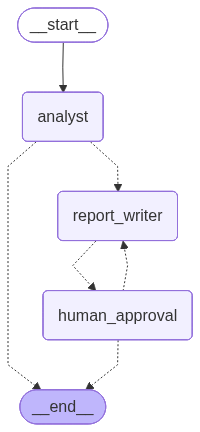

In [31]:
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

checkpointer = InMemorySaver()

graph = make_graph(checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

## Test it out

We need to be careful with the `Command(resume)` in graph stream, because of the interrupts.

Also, I need to test the approval/edit of the report.

In [9]:
user_text = "Perform analysis on dataset1 and dataset2, then write a report."
state = {"messages": [{"role": "user", "content": user_text}]}
config = {"configurable": {"thread_id": "test-123"}}


async for chunk in graph.astream(state, config):
    print(chunk)
            

***assigning to report writer
***state['write_report']: True
***routing to report_writer
***goto: report_writer
{'analyst': {'messages': [AIMessage(content='The analysis of dataset1 and dataset2 is complete, including data loading and plotting. The results are now ready for the report writer to prepare the report.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 630, 'total_tokens': 662, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_422e2d36a8', 'id': 'chatcmpl-CUGjPyrpkBj6Or3J50O04JxNgmu4J', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--f33990f6-31d9-4592-8650-e187f5d59fcc-0', usage_metadata={'input_tokens': 630, 'output_tokens': 32, 'to

In [10]:
state = graph.get_state(config)
for key, value in state.values.items():
    print(key, value)

messages [HumanMessage(content='Perform analysis on dataset1 and dataset2, then write a report.', additional_kwargs={}, response_metadata={}, id='d0be7b40-d055-4a30-9f38-7415dc24906c'), AIMessage(content='The analysis of dataset1 and dataset2 is complete, including data loading and plotting. The results are now ready for the report writer to prepare the report.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 630, 'total_tokens': 662, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_422e2d36a8', 'id': 'chatcmpl-CUGjPyrpkBj6Or3J50O04JxNgmu4J', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--f33990f6-31d9-4592-8650-e187f5d59fcc-0', usage_metadat

In [11]:
user_msg = "yes"
if user_msg == "yes":
    resume_value = {'type': 'accept'}
else:
    resume_value = {'type': 'reject'}

async for chunk in graph.astream(Command(resume=resume_value), config):
    print(chunk)

***using write_report***
asking for report writing approval
{'report_writer': {'messages': [AIMessage(content='Here is the report based on the analysis performed:\n\n# Comparative Analysis of Dataset1 and Dataset2\n\n## Introduction\n\nThis report presents a comparative analysis of two datasets, referred to as dataset1 and dataset2. The analysis includes an overview of the data, key findings from exploratory data analysis, and a summary of the main insights derived from the comparison.\n\n## Data Overview\n\nBoth dataset1 and dataset2 were loaded and inspected to understand their structure and content. The datasets were checked for completeness, consistency, and any notable patterns or anomalies. Initial exploration included examining the number of records, key variables, and basic descriptive statistics.\n\n## Exploratory Data Analysis\n\nVisualizations and summary statistics were generated for both datasets. This included plotting distributions of key variables and comparing central 

In [12]:
state = graph.get_state(config)

In [13]:
for key, value in state.values.items():
    print(key, value)

messages [HumanMessage(content='Perform analysis on dataset1 and dataset2, then write a report.', additional_kwargs={}, response_metadata={}, id='d0be7b40-d055-4a30-9f38-7415dc24906c'), AIMessage(content='The analysis of dataset1 and dataset2 is complete, including data loading and plotting. The results are now ready for the report writer to prepare the report.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 630, 'total_tokens': 662, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_422e2d36a8', 'id': 'chatcmpl-CUGjPyrpkBj6Or3J50O04JxNgmu4J', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--f33990f6-31d9-4592-8650-e187f5d59fcc-0', usage_metadat

In [14]:
user_msg = "accept"
if user_msg == "accept":
    resume_value = {'type': 'accept'}
else:
    resume_value = {'type': 'edit', 'edit_instructions': 'Make it less detailed'}

async for chunk in graph.astream(Command(resume=resume_value), config):
    print(chunk)

{'human_approval': None}


## Test it out with `astream_events()` (like in API)

In [65]:
user_text = "Perform analysis on dataset1 and dataset2, then write a report."
state = {"messages": [{"role": "user", "content": user_text}]}
config = {"configurable": {"thread_id": "test-123"}}
            

In [67]:
async for event in graph.astream_events(state, config, version="v2"):
    data = event.get("data", {})
    name = event.get("name")
    chunk = data.get("chunk")
    if chunk and isinstance(chunk, dict) and '__interrupt__' in chunk:
        interrupt_data = chunk['__interrupt__']
        print(f"🛑 GRAPH INTERRUPTED")
        print(f"Interrupt value: {interrupt_data[0].value}")  # The Interrupt object
        # Handle the interrupt - break, return, set a flag, etc.
    if chunk:
        print(chunk)


content='' additional_kwargs={} response_metadata={'model_provider': 'openai'} id='lc_run--9dbd9e27-8ad1-41b4-a298-81dcfb763ba9'
content='' additional_kwargs={} response_metadata={'model_provider': 'openai'} id='lc_run--9dbd9e27-8ad1-41b4-a298-81dcfb763ba9' tool_calls=[{'name': 'select_dataset', 'args': {}, 'id': 'call_yCxyeCMgZ82lvHOpF9KYWHn5', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'select_dataset', 'args': '', 'id': 'call_yCxyeCMgZ82lvHOpF9KYWHn5', 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={} response_metadata={'model_provider': 'openai'} id='lc_run--9dbd9e27-8ad1-41b4-a298-81dcfb763ba9' tool_calls=[{'name': '', 'args': {}, 'id': None, 'type': 'tool_call'}] tool_call_chunks=[{'name': None, 'args': '{"da', 'id': None, 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={} response_metadata={'model_provider': 'openai'} id='lc_run--9dbd9e27-8ad1-41b4-a298-81dcfb763ba9' invalid_tool_calls=[{'name': None, 'args': 'taset', 'id': None, 

It correclty stopped for human approval before using write report

In [68]:
state = graph.get_state(config)
for key, value in state.values.items():
    print(key, value)

messages [HumanMessage(content='Perform analysis on dataset1 and dataset2, then write a report.', additional_kwargs={}, response_metadata={}, id='e8596a85-d632-464a-aef1-e8f70e16b5ec'), AIMessage(content='The analysis and plotting for dataset1 and dataset2 are complete. The results are now ready for report writing.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_144ea3b974', 'service_tier': 'default', 'model_provider': 'openai'}, id='lc_run--b4f467cf-1cdc-4b30-8b13-c578f5389811', usage_metadata={'input_tokens': 630, 'output_tokens': 23, 'total_tokens': 653, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), AIMessage(content='Here is the report based on the analysis performed:\n\n# Comparative Analysis of Dataset1 and Dataset2\n\n## Introduction\n\nThis report presents a comparative analysis of two datasets, referred to as dataset1 and dataset2. T

Simulate user approval

In [69]:
user_msg = "yes"
if user_msg == "yes":
    resume_value = {'type': 'accept'}
else:
    resume_value = {'type': 'reject'}

In [70]:
async for event in graph.astream_events(Command(resume=resume_value), config, version="v2"):
    event_type = event.get("event")
    data = event.get("data", {})
    name = event.get("name")
    chunk = data.get("chunk")
    if chunk and isinstance(chunk, dict) and '__interrupt__' in chunk:
        interrupt_data = chunk['__interrupt__']
        print(f"🛑 GRAPH INTERRUPTED")
        print(f"Interrupt value: {interrupt_data[0].value}")  # The Interrupt object
        # Handle the interrupt - break, return, set a flag, etc.
    if chunk:
        print(chunk)

***using write_report***
asking for report writing approval
[Command(update={'messages': [ToolMessage(content='Report written', name='write_report', id='334cb7f3-8a24-4791-895f-23c64066fa95', tool_call_id='call_0hwUnt83LwhlZEutzPyl8WRb')], 'reports': {'Comparative Analysis of Dataset1 and Dataset2': '## Introduction\n\nThis report presents a summary of the analysis performed on two datasets, referred to as dataset1 and dataset2. The objective is to compare their main characteristics and highlight any notable findings based on the available data.\n\n## Overview of Datasets\n\nBoth dataset1 and dataset2 were examined to understand their structure and content. Descriptive statistics such as mean, median, and standard deviation were calculated for each dataset. The distributions of the data were also reviewed to identify any patterns or anomalies.\n\n## Key Findings\n\n- **Descriptive Statistics:**\n  - Dataset1 and dataset2 were summarized using standard statistical measures. Central tend

Correctly accepted, used tool, and now asking for human approval

Simulate edit first:

In [71]:
user_msg = "edit the first section to be in italian"
if user_msg == "accept":
    resume_value2 = {'type': 'accept'}
else:
    resume_value2 = {'type': 'edit', 'edit_instructions': user_msg}

In [72]:
async for event in graph.astream_events(Command(resume=resume_value2), config, version="v2"):
    event_type = event.get("event")
    data = event.get("data", {})
    name = event.get("name")
    chunk = data.get("chunk")
    # Check if this chunk contains an interrupt
    if chunk and isinstance(chunk, dict) and '__interrupt__' in chunk:
        interrupt_data = chunk['__interrupt__']
        print(f"🛑 GRAPH INTERRUPTED")
        print(f"Interrupt value: {interrupt_data[0].value}")  # The Interrupt object
        # Handle the interrupt - break, return, set a flag, etc.
    if chunk:
        print(chunk)

***human approval
Command(update={'edit_instructions': 'edit the first section to be in italian'}, goto='report_writer')
{'human_approval': {'edit_instructions': 'edit the first section to be in italian'}}
content='' additional_kwargs={} response_metadata={'model_provider': 'openai'} id='lc_run--2256f13c-e40d-4387-93ab-037a1cd87cf0' tool_calls=[{'name': 'write_report', 'args': {}, 'id': 'call_Ek8fe7C9S3PVkOlDuUXhvwN1', 'type': 'tool_call'}] tool_call_chunks=[{'name': 'write_report', 'args': '', 'id': 'call_Ek8fe7C9S3PVkOlDuUXhvwN1', 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={} response_metadata={'model_provider': 'openai'} id='lc_run--2256f13c-e40d-4387-93ab-037a1cd87cf0' tool_calls=[{'name': '', 'args': {}, 'id': None, 'type': 'tool_call'}] tool_call_chunks=[{'name': None, 'args': '{"', 'id': None, 'index': 0, 'type': 'tool_call_chunk'}]
content='' additional_kwargs={} response_metadata={'model_provider': 'openai'} id='lc_run--2256f13c-e40d-4387-93ab-037a1cd

Correctly edited. Simulate approval:

In [73]:
user_msg = "accept"
if user_msg == "accept":
    resume_value3 = {'type': 'accept'}
else:
    resume_value3 = {'type': 'edit', 'edit_instructions': 'Make it less detailed'}

async for event in graph.astream_events(Command(resume=resume_value3), config, version="v2"):
    data = event.get("data", {})
    chunk = data.get("chunk")
    # Check if this chunk contains an interrupt
    if chunk and isinstance(chunk, dict) and '__interrupt__' in chunk:
        interrupt_data = chunk['__interrupt__']
        print(f"🛑 GRAPH INTERRUPTED")
        print(f"Interrupt value: {interrupt_data[0].value}")  # The Interrupt object
        # Handle the interrupt - break, return, set a flag, etc.
    if chunk:
        print(chunk)


***human approval
Command(goto='__end__')
{'human_approval': None}


### Note

You need to propagate state updates if a tool uses Command and then you invoke in a node.

How it works:
Tool returns Command(update={...}) → Updates are applied to the agent's internal state
Agent returns result → Contains the full updated state after all tools run
Your node returns Command(update={...}) → Only what you specify here gets propagated to the graph's state

The agent result is self-contained - it has the full state after tools ran, but it doesn't automatically merge back. You have to explicitly pass it through.

## Migrations

We have the obvious migrations suggested in v1 of changing imports to `langchain.agents`, but a not very discussed migration is the use of `ToolRuntime` which is now a unique object condensing `InjectedState`, `InjectedToolCallId` etc.

now it works as intended.

>**Note:** we used a workaround in order to be able to route to the report writer in a clean way. I wanted to use a Command, but I have to use Command in the analyst node as well, and nested Commands are nasty af (the tool routes to the agent, but the updates have not been propagated yet..maybe could solve it by propagating the full state in the tool Command?). So in the end I created a tool that just updates a flag in state. The goto then checks that flag.   